In [2]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pydot

### Import edges2shoes Data and Process Into Train / Test

In [3]:
shoe_url = "https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/edges2shoes.tar.gz"

zip_path = tf.keras.utils.get_file('edges2shoes.tar.gz', origin=shoe_url, extract=True)
path = os.path.join(os.path.dirname(zip_path), 'edges2shoes/')

In [4]:
# images in the zip are side by side: left side edges, right side full shoe
# loads image, splits into the two pieces, casts to float, resizes to 256x256, normalizes values to [0, 1]

def process_image(file):
    image = tf.image.decode_jpeg(tf.io.read_file(file)) # load

    width = tf.shape(image)[1]
    width = width // 2
    
    edge = image[:, :width, :] # left side = edges
    shoe = image[:, width:, :] # right side = shoe
    
    edge = tf.cast(edge, tf.float32)
    shoe = tf.cast(shoe, tf.float32)
    
    edge = tf.image.resize(edge, [256, 256])
    shoe = tf.image.resize(shoe, [256, 256])
    
    edge = (edge / 255.0)
    shoe = (shoe / 255.0)

    return edge, shoe

In [5]:
train_ds = tf.data.Dataset.list_files(path + "train/*.jpg")
test_ds = tf.data.Dataset.list_files(path + "val/*.jpg")

In [6]:
train_ds = train_ds.map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# from paper - ran with batch size 4 for 15 epochs
train_ds = train_ds.batch(4)
test_ds = test_ds.batch(4)

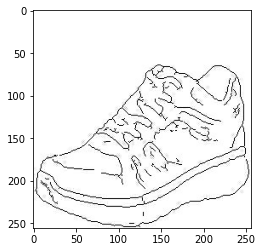

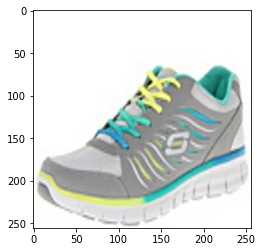

In [7]:
# example images
for shape in train_ds.take(1):
    plt.imshow(shape[0][0].numpy())
    plt.show()
    plt.imshow(shape[1][0].numpy())

### Build Generator Architecture

In [8]:
# Need encoder, decoder (with and without dropout) blocks
# "Weights were initialized from a Gaussian distribution with mean 0 and standard deviation 0.02"

def encode(inputs, filters, kernels):
    weight_init = tf.random_normal_initializer(0.0, 0.02)
    x = tf.keras.layers.Conv2D(filters, kernels, strides=2, padding='same', kernel_initializer=weight_init)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    return x

def decode_with_dropout(inputs, filters, kernels):
    weight_init = tf.random_normal_initializer(0.0, 0.02)
    x = tf.keras.layers.Conv2DTranspose(filters, kernels, strides=2, padding='same', kernel_initializer=weight_init)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.ReLU()(x)
    return x

def decode_no_dropout(inputs, filters, kernels):
    weight_init = tf.random_normal_initializer(0.0, 0.02)
    x = tf.keras.layers.Conv2DTranspose(filters, kernels, strides=2, padding='same', kernel_initializer=weight_init)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

In [9]:
# encode: C64-C128-C256-C512-C512-C512-C512-C512 -> 64 layer does not have BatchNorm
# decode: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
# final stage: convolution to 3 output channels, tanh activation

def Generator():
    inputs = tf.keras.Input(shape=[256, 256, 3]) # all images resized to this shape
    weight_init = tf.random_normal_initializer(0.0, 0.02)
    skip_cons = [] # skip connections, to pair encoding with decoding (one for each encoding layer)
    
    # downsampling
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=weight_init)(inputs)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) # no BatchNorm
    skip_cons.append(x)
    
    x = encode(x, 128, 4)
    skip_cons.append(x)
    
    x = encode(x, 256, 4)
    skip_cons.append(x)
    
    for i in range(5):
        x = encode(x, 512, 4)
        skip_cons.append(x)
        
    # upsampling
    reverse_skips = skip_cons[:-1] # do not include last one - only 7 layers in upsampling (before last layer)
    reverse_skips.reverse()
    
    for i in range(3):
        x = decode_with_dropout(x, 512, 4)
        x = tf.keras.layers.Concatenate()([x, reverse_skips[i]])
        
    x = decode_no_dropout(x, 512, 4)
    x = tf.keras.layers.Concatenate()([x, reverse_skips[3]])
    
    x = decode_no_dropout(x, 256, 4)
    x = tf.keras.layers.Concatenate()([x, reverse_skips[4]])
    
    x = decode_no_dropout(x, 128, 4)
    x = tf.keras.layers.Concatenate()([x, reverse_skips[5]])
    
    x = decode_no_dropout(x, 64, 4)
    x = tf.keras.layers.Concatenate()([x, reverse_skips[6]])
    
    #last layer
    x = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=weight_init, activation='tanh')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

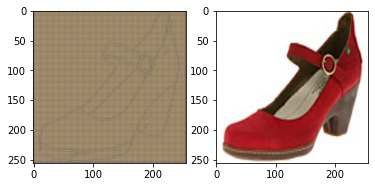

In [40]:
generator = Generator()
pic = next(iter(train_ds))
generated = generator(pic, training = False)
generated = (generated-np.min(generated))/(np.max(generated)-np.min(generated)) # normalized
plt.subplot(1, 2, 1)
plt.imshow(generated[0, ...])
plt.subplot(1, 2, 2)
plt.imshow(pic[1][0])
plt.show()

### Build Discriminator Architecture

In [23]:
# 70 x 70 PatchGAN: C64-C128-C256-C512 (no Batchnorm on first convolution)
# followed by a Conv map to 1d output and a sigmoid function

def Discriminator():
    weight_init = tf.random_normal_initializer(0.0, 0.02)
    
    fake_image = tf.keras.layers.Input(shape=[256, 256, 3])
    target_image = tf.keras.layers.Input(shape=[256, 256, 3])
    
    x = tf.keras.layers.concatenate([fake_image, target_image])
    
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=weight_init)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=weight_init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=weight_init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer=weight_init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same', kernel_initializer=weight_init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same', kernel_initializer=weight_init, activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=[fake_image, target_image], outputs=x)

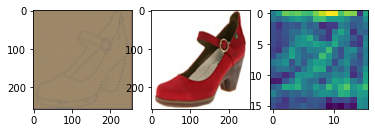

In [41]:
discriminator = Discriminator()
prediction = discriminator([generated[0, tf.newaxis, ...], pic[1][0][tf.newaxis, ...]], training=False)
plt.subplot(1, 3, 1)
plt.imshow(generated[0, ...])
plt.subplot(1, 3, 2)
plt.imshow(pic[1][0])
plt.subplot(1, 3, 3)
plt.imshow(prediction[0,...,-1])
plt.show()

### Full pix2pix Model

In [42]:
# optimizer (same for both, defined in paper)
optimizer = tf.keras.optimizers.Adam(0.002, beta_1 = 0.5, beta_2=0.999)

In [ ]:
# loss functions
# train to maximize log D(x, G(x, z))



### Train on edges2shoes Data